In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import string
import nltk
import torch
import pysentiment2 as ps
import tensorflow as tf
import xgboost as xgb
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Activation

In [2]:
#Reading the dataset
merged_SH_new = pd.read_csv('DJIA_merged.csv')
merged_SH_new

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Adj Close,BERT_Positive,BERT_Negative,...,H_Aggregate,LM_Positive,LM_Negative,LM_Aggregate,Positive_Score,Negative_Score,Neutral_Score,Compound_Score,Polarity,Subjectivity
0,0,2016-07-01,0.966790,0.970024,0.969867,0.969145,0.110651,0.969145,0.588598,0.411402,...,-0.315789,2.0,10.0,-0.666667,0.068,0.302,0.631,-0.9987,-0.006564,0.316409
1,1,2016-06-30,0.948819,0.963859,0.952488,0.967498,0.186974,0.967498,0.585330,0.414670,...,-0.388889,2.0,9.0,-0.636364,0.087,0.297,0.616,-0.9982,0.018968,0.377540
2,2,2016-06-29,0.927002,0.944437,0.930817,0.947497,0.146990,0.947497,0.578757,0.421243,...,-0.400000,1.0,6.0,-0.714286,0.123,0.260,0.617,-0.9943,0.050125,0.387107
3,3,2016-06-28,0.904440,0.919115,0.908321,0.923277,0.155707,0.923277,0.615913,0.384087,...,0.142857,2.0,11.0,-0.692308,0.143,0.172,0.685,-0.9424,0.039465,0.329909
4,4,2016-06-27,0.918436,0.914433,0.897524,0.900373,0.195541,0.900373,0.618050,0.381950,...,-0.263158,1.0,4.0,-0.600000,0.117,0.219,0.664,-0.9839,-0.006098,0.349394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,1984,2008-08-14,0.423610,0.430233,0.422020,0.430832,0.227123,0.430832,0.590350,0.409650,...,-0.083333,0.0,3.0,-1.000000,0.121,0.227,0.652,-0.9805,0.024498,0.328388
1985,1985,2008-08-13,0.432170,0.422975,0.422228,0.423779,0.261271,0.423779,0.578226,0.421774,...,0.040000,1.0,4.0,-0.600000,0.093,0.197,0.709,-0.9758,0.016061,0.370301
1986,1986,2008-08-12,0.444822,0.435737,0.434783,0.433087,0.247828,0.433087,0.508867,0.491133,...,-0.310345,0.0,2.0,-1.000000,0.093,0.251,0.656,-0.9931,-0.036307,0.531229
1987,1987,2008-08-11,0.440401,0.443018,0.441053,0.444976,0.262232,0.444976,0.622814,0.377186,...,-0.250000,2.0,8.0,-0.600000,0.092,0.273,0.635,-0.9888,0.079866,0.334260


In [3]:
#Finding if there are any missing values in the dataset
merged_SH_new.isna().sum()

Unnamed: 0         0
Date               0
Open               0
High               0
Low                0
Close              0
Volume             0
Adj Close          0
BERT_Positive      3
BERT_Negative      3
MiniLM_Positive    3
MiniLM_Negative    3
H_Positive         3
H_Negative         3
H_Aggregate        3
LM_Positive        3
LM_Negative        3
LM_Aggregate       3
Positive_Score     3
Negative_Score     3
Neutral_Score      3
Compound_Score     3
Polarity           3
Subjectivity       3
dtype: int64

In [4]:
#Droping rows with missing values
merged_SH_new = merged_SH_new.dropna()
merged_SH_new

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Adj Close,BERT_Positive,BERT_Negative,...,H_Aggregate,LM_Positive,LM_Negative,LM_Aggregate,Positive_Score,Negative_Score,Neutral_Score,Compound_Score,Polarity,Subjectivity
0,0,2016-07-01,0.966790,0.970024,0.969867,0.969145,0.110651,0.969145,0.588598,0.411402,...,-0.315789,2.0,10.0,-0.666667,0.068,0.302,0.631,-0.9987,-0.006564,0.316409
1,1,2016-06-30,0.948819,0.963859,0.952488,0.967498,0.186974,0.967498,0.585330,0.414670,...,-0.388889,2.0,9.0,-0.636364,0.087,0.297,0.616,-0.9982,0.018968,0.377540
2,2,2016-06-29,0.927002,0.944437,0.930817,0.947497,0.146990,0.947497,0.578757,0.421243,...,-0.400000,1.0,6.0,-0.714286,0.123,0.260,0.617,-0.9943,0.050125,0.387107
3,3,2016-06-28,0.904440,0.919115,0.908321,0.923277,0.155707,0.923277,0.615913,0.384087,...,0.142857,2.0,11.0,-0.692308,0.143,0.172,0.685,-0.9424,0.039465,0.329909
4,4,2016-06-27,0.918436,0.914433,0.897524,0.900373,0.195541,0.900373,0.618050,0.381950,...,-0.263158,1.0,4.0,-0.600000,0.117,0.219,0.664,-0.9839,-0.006098,0.349394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,1984,2008-08-14,0.423610,0.430233,0.422020,0.430832,0.227123,0.430832,0.590350,0.409650,...,-0.083333,0.0,3.0,-1.000000,0.121,0.227,0.652,-0.9805,0.024498,0.328388
1985,1985,2008-08-13,0.432170,0.422975,0.422228,0.423779,0.261271,0.423779,0.578226,0.421774,...,0.040000,1.0,4.0,-0.600000,0.093,0.197,0.709,-0.9758,0.016061,0.370301
1986,1986,2008-08-12,0.444822,0.435737,0.434783,0.433087,0.247828,0.433087,0.508867,0.491133,...,-0.310345,0.0,2.0,-1.000000,0.093,0.251,0.656,-0.9931,-0.036307,0.531229
1987,1987,2008-08-11,0.440401,0.443018,0.441053,0.444976,0.262232,0.444976,0.622814,0.377186,...,-0.250000,2.0,8.0,-0.600000,0.092,0.273,0.635,-0.9888,0.079866,0.334260


In [5]:
#Converting the date to datetime format and sorting
merged_SH_new['Date'] = pd.to_datetime(merged_SH_new['Date'])
merged_SH_new.sort_index(ascending=False, inplace=True)
merged_SH_new

C:\Users\hp\AppData\Local\Temp\ipykernel_18716\277736772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_SH_new['Date'] = pd.to_datetime(merged_SH_new['Date'])
C:\Users\hp\AppData\Local\Temp\ipykernel_18716\277736772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_SH_new.sort_index(ascending=False, inplace=True)


,Unnamed: 0,Date,Open,High,Low,Close,Volume,Adj Close,BERT_Positive,BERT_Negative,...,H_Aggregate,LM_Positive,LM_Negative,LM_Aggregate,Positive_Score,Negative_Score,Neutral_Score,Compound_Score,Polarity,Subjectivity
1988,1988,2008-08-08,0.415114,0.433814,0.416695,0.440894,0.306702,0.440894,0.566489,0.433511,...,-0.230769,0.0,5.0,-1.000000,0.066,0.285,0.649,-0.9972,-0.049365,0.264766
1987,1987,2008-08-11,0.440401,0.443018,0.441053,0.444976,0.262232,0.444976,0.622814,0.377186,...,-0.250000,2.0,8.0,-0.600000,0.092,0.273,0.635,-0.9888,0.079866,0.334260
1986,1986,2008-08-12,0.444822,0.435737,0.434783,0.433087,0.247828,0.433087,0.508867,0.491133,...,-0.310345,0.0,2.0,-1.000000,0.093,0.251,0.656,-0.9931,-0.036307,0.531229
1985,1985,2008-08-13,0.432170,0.422975,0.422228,0.423779,0.261271,0.423779,0.578226,0.421774,...,0.040000,1.0,4.0,-0.600000,0.093,0.197,0.709,-0.9758,0.016061,0.370301
1984,1984,2008-08-14,0.423610,0.430233,0.422020,0.430832,0.227123,0.430832,0.590350,0.409650,...,-0.083333,0.0,3.0,-1.000000,0.121,0.227,0.652,-0.9805,0.024498,0.328388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,4,2016-06-27,0.918436,0.914433,0.897524,0.900373,0.195541,0.900373,0.618050,0.381950,...,-0.263158,1.0,4.0,-0.600000,0.117,0.219,0.664,-0.9839,-0.006098,0.349394
3,3,2016-06-28,0.904440,0.919115,0.908321,0.923277,0.155707,0.923277,0.615913,0.384087,...,0.142857,2.0,11.0,-0.692308,0.143,0.172,0.685,-0.9424,0.039465,0.329909
2,2,2016-06-29,0.927002,0.944437,0.930817,0.947497,0.146990,0.947497,0.578757,0.421243,...,-0.400000,1.0,6.0,-0.714286,0.123,0.260,0.617,-0.9943,0.050125,0.387107
1,1,2016-06-30,0.948819,0.963859,0.952488,0.967498,0.186974,0.967498,0.585330,0.414670,...,-0.388889,2.0,9.0,-0.636364,0.087,0.297,0.616,-0.9982,0.018968,0.377540


# Modeling and Evaluation

## LSTM, Stacked-LSTM and XGBoost with Historical Data

In [6]:
X_hist = merged_SH_new[['Open', 'High', 'Low']]
y_hist = merged_SH_new['Close']

tss = TimeSeriesSplit(n_splits=5)

In [7]:
hist_L_mse = []
hist_L_mae = []
hist_L_r2 = []

for train_index, test_index in tss.split(X_hist):
    X_train, X_test = X_hist.iloc[train_index].values, X_hist.iloc[test_index].values
    y_train, y_test = y_hist.iloc[train_index].values, y_hist.iloc[test_index].values

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model = Sequential()
    model.add(LSTM(units=100, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_LSTM_historical = model.predict(X_test)

    mse_L_historical = mean_squared_error(y_test, y_LSTM_historical)
    mae_L_historical = mean_absolute_error(y_test, y_LSTM_historical)
    r2_L_historical = r2_score(y_test, y_LSTM_historical)

    hist_L_mse.append(mse_L_historical)
    hist_L_mae.append(mae_L_historical)
    hist_L_r2.append(r2_L_historical)
    
print(f"Mean MSE: {np.mean(hist_L_mse)}")
print(f"Mean MAE: {np.mean(hist_L_mae)}")
print(f"Mean R-squared: {np.mean(hist_L_r2)}")

11/11 [==============================] - 1s 3ms/step
Mean MSE: 7.302153541868814e-05
Mean MAE: 0.006586539132323857
Mean R-squared: 0.9769724669205537


In [8]:
hist_S_mse = []
hist_S_mae = []
hist_S_r2 = []

for train_index, test_index in tss.split(X_hist):
    X_train, X_test = X_hist.iloc[train_index].values, X_hist.iloc[test_index].values
    y_train, y_test = y_hist.iloc[train_index].values, y_hist.iloc[test_index].values

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model_S = Sequential()
    model_S.add(LSTM(units=100, input_shape=(X_train.shape[1], 1), return_sequences=True)) 
    model_S.add(LSTM(units=100, return_sequences=True))
    model_S.add(LSTM(units=100))
    model_S.add(Dense(1))
    model_S.compile(loss='mean_squared_error', optimizer='adam')
    model_S.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_SLSTM_historical = model_S.predict(X_test)

    mse_S_historical = mean_squared_error(y_test, y_SLSTM_historical)
    mae_S_historical = mean_absolute_error(y_test, y_SLSTM_historical)
    r2_S_historical = r2_score(y_test, y_SLSTM_historical)

    hist_S_mse.append(mse_S_historical)
    hist_S_mae.append(mae_S_historical)
    hist_S_r2.append(r2_S_historical)
    
print(f"Mean MSE: {np.mean(hist_S_mse)}")
print(f"Mean MAE: {np.mean(hist_S_mae)}")
print(f"Mean R-squared: {np.mean(hist_S_r2)}")

11/11 [==============================] - 4s 7ms/step
Mean MSE: 0.00011661247631560973
Mean MAE: 0.008035645014178994
Mean R-squared: 0.9634356348502763


In [9]:
hist_X_mse = []
hist_X_mae = []
hist_X_r2 = []

for train_index, test_index in tss.split(X_hist):
    X_train, X_test = X_hist.iloc[train_index].values, X_hist.iloc[test_index].values
    y_train, y_test = y_hist.iloc[train_index].values, y_hist.iloc[test_index].values

    XGBoost = xgb.XGBRegressor()
    XGBoost = XGBoost.fit(X_train, y_train)
    y_XGBoost_historical = XGBoost.predict(X_test)

    mse_X_historical = mean_squared_error(y_test, y_XGBoost_historical)
    mae_X_historical = mean_absolute_error(y_test, y_XGBoost_historical)
    r2_X_historical = r2_score(y_test, y_XGBoost_historical)

    hist_X_mse.append(mse_X_historical)
    hist_X_mae.append(mae_X_historical)
    hist_X_r2.append(r2_X_historical)
    
print(f"Mean MSE: {np.mean(hist_X_mse)}")
print(f"Mean MAE: {np.mean(hist_X_mae)}")
print(f"Mean R-squared: {np.mean(hist_X_r2)}")

Mean MSE: 0.005588235503231339
Mean MAE: 0.04560065592020942
Mean R-squared: -0.3035945024785588


# LSTM, Stacked-LSTM and XGBoost with BERT

In [10]:
X_B = merged_SH_new[['Open', 'High', 'Low', 'BERT_Positive', 'BERT_Negative']]
y_B = merged_SH_new['Close']

tss = TimeSeriesSplit(n_splits=5)

In [11]:
B_L_mse = []
B_L_mae = []
B_L_r2 = []

for train_index, test_index in tss.split(X_B):
    X_train, X_test = X_B.iloc[train_index].values, X_B.iloc[test_index].values
    y_train, y_test = y_B.iloc[train_index].values, y_B.iloc[test_index].values

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model = Sequential()
    model.add(LSTM(units=100, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_LSTM_B = model.predict(X_test)

    mse_L_B = mean_squared_error(y_test, y_LSTM_B)
    mae_L_B = mean_absolute_error(y_test, y_LSTM_B)
    r2_L_B = r2_score(y_test, y_LSTM_B)

    B_L_mse.append(mse_L_B)
    B_L_mae.append(mae_L_B)
    B_L_r2.append(r2_L_B)
    
print(f"Mean MSE: {np.mean(B_L_mse)}")
print(f"Mean MAE: {np.mean(B_L_mae)}")
print(f"Mean R-squared: {np.mean(B_L_r2)}")

11/11 [==============================] - 1s 4ms/step
Mean MSE: 8.164084680526101e-05
Mean MAE: 0.007004523833021889
Mean R-squared: 0.9745939832502059


In [12]:
B_S_mse = []
B_S_mae = []
B_S_r2 = []

for train_index, test_index in tss.split(X_B):
    X_train, X_test = X_B.iloc[train_index].values, X_B.iloc[test_index].values
    y_train, y_test = y_B.iloc[train_index].values, y_B.iloc[test_index].values

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model_S = Sequential()
    model_S.add(LSTM(units=100, input_shape=(X_train.shape[1], 1), return_sequences=True)) 
    model_S.add(LSTM(units=100, return_sequences=True))
    model_S.add(LSTM(units=100))
    model_S.add(Dense(1))
    model_S.compile(loss='mean_squared_error', optimizer='adam')
    model_S.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_SLSTM_B = model_S.predict(X_test)

    mse_S_B = mean_squared_error(y_test, y_SLSTM_B)
    mae_S_B = mean_absolute_error(y_test, y_SLSTM_B)
    r2_S_B = r2_score(y_test, y_SLSTM_B)

    B_S_mse.append(mse_S_B)
    B_S_mae.append(mae_S_B)
    B_S_r2.append(r2_S_B)
    
print(f"Mean MSE: {np.mean(B_S_mse)}")
print(f"Mean MAE: {np.mean(B_S_mae)}")
print(f"Mean R-squared: {np.mean(B_S_r2)}")

11/11 [==============================] - 2s 7ms/step
Mean MSE: 9.406686735163969e-05
Mean MAE: 0.0075845527476320505
Mean R-squared: 0.9732263445098468


In [13]:
B_X_mse = []
B_X_mae = []
B_X_r2 = []

for train_index, test_index in tss.split(X_B):
    X_train, X_test = X_B.iloc[train_index].values, X_B.iloc[test_index].values
    y_train, y_test = y_B.iloc[train_index].values, y_B.iloc[test_index].values

    XGBoost = xgb.XGBRegressor()
    XGBoost = XGBoost.fit(X_train, y_train)
    y_XGBoost_B = XGBoost.predict(X_test)

    mse_X_B = mean_squared_error(y_test, y_XGBoost_B)
    mae_X_B = mean_absolute_error(y_test, y_XGBoost_B)
    r2_X_B = r2_score(y_test, y_XGBoost_B)

    B_X_mse.append(mse_X_B)
    B_X_mae.append(mae_X_B)
    B_X_r2.append(r2_X_B)
    
print(f"Mean MSE: {np.mean(B_X_mse)}")
print(f"Mean MAE: {np.mean(B_X_mae)}")
print(f"Mean R-squared: {np.mean(B_X_r2)}")

Mean MSE: 0.005597955330121841
Mean MAE: 0.046020046356753726
Mean R-squared: -0.3029114927849105


# LSTM, Stacked-LSTM and XGBoost with MiniLM

In [14]:
X_M = merged_SH_new[['Open', 'High', 'Low', 'MiniLM_Positive', 'MiniLM_Negative']]
y_M = merged_SH_new['Close']

tss = TimeSeriesSplit(n_splits=5)

In [15]:
M_L_mse = []
M_L_mae = []
M_L_r2 = []

for train_index, test_index in tss.split(X_M):
    X_train, X_test = X_M.iloc[train_index].values, X_M.iloc[test_index].values
    y_train, y_test = y_M.iloc[train_index].values, y_M.iloc[test_index].values

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model = Sequential()
    model.add(LSTM(units=100, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_LSTM_M = model.predict(X_test)

    mse_L_M = mean_squared_error(y_test, y_LSTM_M)
    mae_L_M = mean_absolute_error(y_test, y_LSTM_M)
    r2_L_M = r2_score(y_test, y_LSTM_M)

    M_L_mse.append(mse_L_M)
    M_L_mae.append(mae_L_M)
    M_L_r2.append(r2_L_M)
    
print(f"Mean MSE: {np.mean(M_L_mse)}")
print(f"Mean MAE: {np.mean(M_L_mae)}")
print(f"Mean R-squared: {np.mean(M_L_r2)}")

11/11 [==============================] - 1s 5ms/step
Mean MSE: 5.719657930620778e-05
Mean MAE: 0.005757950836267265
Mean R-squared: 0.9826472430999015


In [16]:
M_S_mse = []
M_S_mae = []
M_S_r2 = []

for train_index, test_index in tss.split(X_M):
    X_train, X_test = X_M.iloc[train_index].values, X_M.iloc[test_index].values
    y_train, y_test = y_M.iloc[train_index].values, y_M.iloc[test_index].values

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model_S = Sequential()
    model_S.add(LSTM(units=100, input_shape=(X_train.shape[1], 1), return_sequences=True)) 
    model_S.add(LSTM(units=100, return_sequences=True))
    model_S.add(LSTM(units=100))
    model_S.add(Dense(1))
    model_S.compile(loss='mean_squared_error', optimizer='adam')
    model_S.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_SLSTM_M = model_S.predict(X_test)

    mse_S_M = mean_squared_error(y_test, y_SLSTM_M)
    mae_S_M = mean_absolute_error(y_test, y_SLSTM_M)
    r2_S_M = r2_score(y_test, y_SLSTM_M)

    M_S_mse.append(mse_S_M)
    M_S_mae.append(mae_S_M)
    M_S_r2.append(r2_S_M)
    
print(f"Mean MSE: {np.mean(M_S_mse)}")
print(f"Mean MAE: {np.mean(M_S_mae)}")
print(f"Mean R-squared: {np.mean(M_S_r2)}")

11/11 [==============================] - 2s 9ms/step
Mean MSE: 0.00011320877334948404
Mean MAE: 0.00877645118724922
Mean R-squared: 0.9652055541023117


In [17]:
M_X_mse = []
M_X_mae = []
M_X_r2 = []

for train_index, test_index in tss.split(X_M):
    X_train, X_test = X_M.iloc[train_index].values, X_M.iloc[test_index].values
    y_train, y_test = y_M.iloc[train_index].values, y_M.iloc[test_index].values

    XGBoost = xgb.XGBRegressor()
    XGBoost = XGBoost.fit(X_train, y_train)
    y_XGBoost_M = XGBoost.predict(X_test)

    mse_X_M = mean_squared_error(y_test, y_XGBoost_M)
    mae_X_M = mean_absolute_error(y_test, y_XGBoost_M)
    r2_X_M = r2_score(y_test, y_XGBoost_M)

    M_X_mse.append(mse_X_M)
    M_X_mae.append(mae_X_M)
    M_X_r2.append(r2_X_M)
    
print(f"Mean MSE: {np.mean(M_X_mse)}")
print(f"Mean MAE: {np.mean(M_X_mae)}")
print(f"Mean R-squared: {np.mean(M_X_r2)}")

Mean MSE: 0.00571462648230791
Mean MAE: 0.04658565167705431
Mean R-squared: -0.3476322448874353


## LSTM, Stacked-LSTM and XGBoost with VADER

In [18]:
X_V = merged_SH_new[['Open', 'High', 'Low', 'Positive_Score', 'Negative_Score', 'Neutral_Score', 
                     'Compound_Score']]
y_V = merged_SH_new['Close']

tss = TimeSeriesSplit(n_splits=5)

In [19]:
V_L_mse = []
V_L_mae = []
V_L_r2 = []

for train_index, test_index in tss.split(X_V):
    X_train, X_test = X_V.iloc[train_index].values, X_V.iloc[test_index].values
    y_train, y_test = y_V.iloc[train_index].values, y_V.iloc[test_index].values

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model = Sequential()
    model.add(LSTM(units=100, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_LSTM_V = model.predict(X_test)

    mse_L_V = mean_squared_error(y_test, y_LSTM_V)
    mae_L_V = mean_absolute_error(y_test, y_LSTM_V)
    r2_L_V = r2_score(y_test, y_LSTM_V)

    V_L_mse.append(mse_L_V)
    V_L_mae.append(mae_L_V)
    V_L_r2.append(r2_L_V)
    
print(f"Mean MSE: {np.mean(V_L_mse)}")
print(f"Mean MAE: {np.mean(V_L_mae)}")
print(f"Mean R-squared: {np.mean(V_L_r2)}")

11/11 [==============================] - 1s 5ms/step
Mean MSE: 0.00015283863531523166
Mean MAE: 0.009754417765450924
Mean R-squared: 0.963815537301491


In [20]:
V_S_mse = []
V_S_mae = []
V_S_r2 = []

for train_index, test_index in tss.split(X_V):
    X_train, X_test = X_V.iloc[train_index].values, X_V.iloc[test_index].values
    y_train, y_test = y_V.iloc[train_index].values, y_V.iloc[test_index].values

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model_S = Sequential()
    model_S.add(LSTM(units=100, input_shape=(X_train.shape[1], 1), return_sequences=True)) 
    model_S.add(LSTM(units=100, return_sequences=True))
    model_S.add(LSTM(units=100))
    model_S.add(Dense(1))
    model_S.compile(loss='mean_squared_error', optimizer='adam')
    model_S.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_SLSTM_V = model_S.predict(X_test)

    mse_S_V = mean_squared_error(y_test, y_SLSTM_V)
    mae_S_V = mean_absolute_error(y_test, y_SLSTM_V)
    r2_S_V = r2_score(y_test, y_SLSTM_V)

    V_S_mse.append(mse_S_V)
    V_S_mae.append(mae_S_V)
    V_S_r2.append(r2_S_V)
    
print(f"Mean MSE: {np.mean(V_S_mse)}")
print(f"Mean MAE: {np.mean(V_S_mae)}")
print(f"Mean R-squared: {np.mean(V_S_r2)}")

11/11 [==============================] - 2s 11ms/step
Mean MSE: 0.00018673967967260862
Mean MAE: 0.010992549900125657
Mean R-squared: 0.9465754368966308


In [21]:
V_X_mse = []
V_X_mae = []
V_X_r2 = []

for train_index, test_index in tss.split(X_V):
    X_train, X_test = X_V.iloc[train_index].values, X_V.iloc[test_index].values
    y_train, y_test = y_V.iloc[train_index].values, y_V.iloc[test_index].values

    XGBoost = xgb.XGBRegressor()
    XGBoost = XGBoost.fit(X_train, y_train)
    y_XGBoost_V = XGBoost.predict(X_test)

    mse_X_V = mean_squared_error(y_test, y_XGBoost_V)
    mae_X_V = mean_absolute_error(y_test, y_XGBoost_V)
    r2_X_V = r2_score(y_test, y_XGBoost_V)

    V_X_mse.append(mse_X_V)
    V_X_mae.append(mae_X_V)
    V_X_r2.append(r2_X_V)
    
print(f"Mean MSE: {np.mean(V_X_mse)}")
print(f"Mean MAE: {np.mean(V_X_mae)}")
print(f"Mean R-squared: {np.mean(V_X_r2)}")

Mean MSE: 0.0058008931756037205
Mean MAE: 0.04736944351341513
Mean R-squared: -0.3640780480905229


## LSTM, Stacked-LSTM and XGBoost with TextBlob

In [22]:
X_T = merged_SH_new[['Open', 'High', 'Low', 'Polarity', 'Subjectivity']]
y_T = merged_SH_new['Close']

tss = TimeSeriesSplit(n_splits=5)

In [23]:
T_L_mse = []
T_L_mae = []
T_L_r2 = []

for train_index, test_index in tss.split(X_T):
    X_train, X_test = X_T.iloc[train_index].values, X_T.iloc[test_index].values
    y_train, y_test = y_T.iloc[train_index].values, y_T.iloc[test_index].values

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model = Sequential()
    model.add(LSTM(units=100, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_LSTM_T = model.predict(X_test)

    mse_L_T = mean_squared_error(y_test, y_LSTM_T)
    mae_L_T = mean_absolute_error(y_test, y_LSTM_T)
    r2_L_T = r2_score(y_test, y_LSTM_T)

    T_L_mse.append(mse_L_T)
    T_L_mae.append(mae_L_T)
    T_L_r2.append(r2_L_T)
    
print(f"Mean MSE: {np.mean(T_L_mse)}")
print(f"Mean MAE: {np.mean(T_L_mae)}")
print(f"Mean R-squared: {np.mean(T_L_r2)}")

11/11 [==============================] - 1s 4ms/step
Mean MSE: 0.00011532067128977115
Mean MAE: 0.008366121597545656
Mean R-squared: 0.9645137296913264


In [24]:
T_S_mse = []
T_S_mae = []
T_S_r2 = []

for train_index, test_index in tss.split(X_T):
    X_train, X_test = X_T.iloc[train_index].values, X_T.iloc[test_index].values
    y_train, y_test = y_T.iloc[train_index].values, y_T.iloc[test_index].values

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model_S = Sequential()
    model_S.add(LSTM(units=100, input_shape=(X_train.shape[1], 1), return_sequences=True)) 
    model_S.add(LSTM(units=100, return_sequences=True))
    model_S.add(LSTM(units=100))
    model_S.add(Dense(1))
    model_S.compile(loss='mean_squared_error', optimizer='adam')
    model_S.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_SLSTM_T = model_S.predict(X_test)

    mse_S_T = mean_squared_error(y_test, y_SLSTM_T)
    mae_S_T = mean_absolute_error(y_test, y_SLSTM_T)
    r2_S_T = r2_score(y_test, y_SLSTM_T)

    T_S_mse.append(mse_S_T)
    T_S_mae.append(mae_S_T)
    T_S_r2.append(r2_S_T)
    
print(f"Mean MSE: {np.mean(T_S_mse)}")
print(f"Mean MAE: {np.mean(T_S_mae)}")
print(f"Mean R-squared: {np.mean(T_S_r2)}")

11/11 [==============================] - 2s 9ms/step
Mean MSE: 0.00016285611236659282
Mean MAE: 0.010126279024450725
Mean R-squared: 0.9495245431302985


In [25]:
T_X_mse = []
T_X_mae = []
T_X_r2 = []

for train_index, test_index in tss.split(X_T):
    X_train, X_test = X_T.iloc[train_index].values, X_T.iloc[test_index].values
    y_train, y_test = y_T.iloc[train_index].values, y_T.iloc[test_index].values

    XGBoost = xgb.XGBRegressor()
    XGBoost = XGBoost.fit(X_train, y_train)
    y_XGBoost_T = XGBoost.predict(X_test)

    mse_X_T = mean_squared_error(y_test, y_XGBoost_T)
    mae_X_T = mean_absolute_error(y_test, y_XGBoost_T)
    r2_X_T = r2_score(y_test, y_XGBoost_T)

    T_X_mse.append(mse_X_T)
    T_X_mae.append(mae_X_T)
    T_X_r2.append(r2_X_T)
    
print(f"Mean MSE: {np.mean(T_X_mse)}")
print(f"Mean MAE: {np.mean(T_X_mae)}")
print(f"Mean R-squared: {np.mean(T_X_r2)}")

Mean MSE: 0.005736725114928993
Mean MAE: 0.046812722288079846
Mean R-squared: -0.3425773231245695


## LSTM, Stacked-LSTM and XGBoost with LM

In [26]:
X_L = merged_SH_new[['Open', 'High', 'Low', 'LM_Positive', 'LM_Negative', 'LM_Aggregate']]
y_L = merged_SH_new['Close']

tss = TimeSeriesSplit(n_splits=5)

In [27]:
L_L_mse = []
L_L_mae = []
L_L_r2 = []

for train_index, test_index in tss.split(X_L):
    X_train, X_test = X_L.iloc[train_index].values, X_L.iloc[test_index].values
    y_train, y_test = y_L.iloc[train_index].values, y_L.iloc[test_index].values

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model = Sequential()
    model.add(LSTM(units=100, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_LSTM_L = model.predict(X_test)

    mse_L_L = mean_squared_error(y_test, y_LSTM_L)
    mae_L_L = mean_absolute_error(y_test, y_LSTM_L)
    r2_L_L = r2_score(y_test, y_LSTM_L)

    L_L_mse.append(mse_L_L)
    L_L_mae.append(mae_L_L)
    L_L_r2.append(r2_L_L)
    
print(f"Mean MSE: {np.mean(L_L_mse)}")
print(f"Mean MAE: {np.mean(L_L_mae)}")
print(f"Mean R-squared: {np.mean(L_L_r2)}")

11/11 [==============================] - 1s 5ms/step
Mean MSE: 0.00020809337782018441
Mean MAE: 0.010989784535237553
Mean R-squared: 0.938870325955197


In [28]:
L_S_mse = []
L_S_mae = []
L_S_r2 = []

for train_index, test_index in tss.split(X_L):
    X_train, X_test = X_L.iloc[train_index].values, X_L.iloc[test_index].values
    y_train, y_test = y_L.iloc[train_index].values, y_L.iloc[test_index].values

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model_S = Sequential()
    model_S.add(LSTM(units=100, input_shape=(X_train.shape[1], 1), return_sequences=True)) 
    model_S.add(LSTM(units=100, return_sequences=True))
    model_S.add(LSTM(units=100))
    model_S.add(Dense(1))
    model_S.compile(loss='mean_squared_error', optimizer='adam')
    model_S.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_SLSTM_L = model_S.predict(X_test)

    mse_S_L = mean_squared_error(y_test, y_SLSTM_L)
    mae_S_L = mean_absolute_error(y_test, y_SLSTM_L)
    r2_S_L = r2_score(y_test, y_SLSTM_L)

    L_S_mse.append(mse_S_L)
    L_S_mae.append(mae_S_L)
    L_S_r2.append(r2_S_L)
    
print(f"Mean MSE: {np.mean(L_S_mse)}")
print(f"Mean MAE: {np.mean(L_S_mae)}")
print(f"Mean R-squared: {np.mean(L_S_r2)}")

11/11 [==============================] - 2s 11ms/step
Mean MSE: 0.00022184729122352032
Mean MAE: 0.011962553324423798
Mean R-squared: 0.9367835683456486


In [29]:
L_X_mse = []
L_X_mae = []
L_X_r2 = []

for train_index, test_index in tss.split(X_L):
    X_train, X_test = X_L.iloc[train_index].values, X_L.iloc[test_index].values
    y_train, y_test = y_L.iloc[train_index].values, y_L.iloc[test_index].values

    XGBoost = xgb.XGBRegressor()
    XGBoost = XGBoost.fit(X_train, y_train)
    y_XGBoost_L = XGBoost.predict(X_test)

    mse_X_L = mean_squared_error(y_test, y_XGBoost_L)
    mae_X_L = mean_absolute_error(y_test, y_XGBoost_L)
    r2_X_L = r2_score(y_test, y_XGBoost_L)

    L_X_mse.append(mse_X_L)
    L_X_mae.append(mae_X_L)
    L_X_r2.append(r2_X_L)
    
print(f"Mean MSE: {np.mean(L_X_mse)}")
print(f"Mean MAE: {np.mean(L_X_mae)}")
print(f"Mean R-squared: {np.mean(L_X_r2)}")

Mean MSE: 0.005660140963189899
Mean MAE: 0.04646864046347775
Mean R-squared: -0.3184132942330832


## LSTM, Stacked-LSTM and XGBoost with H

In [30]:
X_H = merged_SH_new[['Open', 'High', 'Low', 'H_Positive', 'H_Negative', 'H_Aggregate']]
y_H = merged_SH_new['Close']

tss = TimeSeriesSplit(n_splits=5)

In [31]:
H_L_mse = []
H_L_mae = []
H_L_r2 = []

for train_index, test_index in tss.split(X_H):
    X_train, X_test = X_H.iloc[train_index].values, X_H.iloc[test_index].values
    y_train, y_test = y_H.iloc[train_index].values, y_H.iloc[test_index].values

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model = Sequential()
    model.add(LSTM(units=100, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_LSTM_H = model.predict(X_test)

    mse_L_H = mean_squared_error(y_test, y_LSTM_H)
    mae_L_H = mean_absolute_error(y_test, y_LSTM_H)
    r2_L_H = r2_score(y_test, y_LSTM_H)

    H_L_mse.append(mse_L_H)
    H_L_mae.append(mae_L_H)
    H_L_r2.append(r2_L_H)
    
print(f"Mean MSE: {np.mean(H_L_mse)}")
print(f"Mean MAE: {np.mean(H_L_mae)}")
print(f"Mean R-squared: {np.mean(H_L_r2)}")

11/11 [==============================] - 1s 9ms/step
Mean MSE: 0.00033433838548006063
Mean MAE: 0.014103483213871369
Mean R-squared: 0.9212301760051735


In [32]:
H_S_mse = []
H_S_mae = []
H_S_r2 = []

for train_index, test_index in tss.split(X_H):
    X_train, X_test = X_H.iloc[train_index].values, X_H.iloc[test_index].values
    y_train, y_test = y_H.iloc[train_index].values, y_H.iloc[test_index].values

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model_S = Sequential()
    model_S.add(LSTM(units=100, input_shape=(X_train.shape[1], 1), return_sequences=True)) 
    model_S.add(LSTM(units=100, return_sequences=True))
    model_S.add(LSTM(units=100))
    model_S.add(Dense(1))
    model_S.compile(loss='mean_squared_error', optimizer='adam')
    model_S.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_SLSTM_H = model_S.predict(X_test)

    mse_S_H = mean_squared_error(y_test, y_SLSTM_H)
    mae_S_H = mean_absolute_error(y_test, y_SLSTM_H)
    r2_S_H = r2_score(y_test, y_SLSTM_H)

    H_S_mse.append(mse_S_H)
    H_S_mae.append(mae_S_H)
    H_S_r2.append(r2_S_H)
    
print(f"Mean MSE: {np.mean(H_S_mse)}")
print(f"Mean MAE: {np.mean(H_S_mae)}")
print(f"Mean R-squared: {np.mean(H_S_r2)}")

11/11 [==============================] - 2s 8ms/step
Mean MSE: 0.0003667491109103996
Mean MAE: 0.013733786462779413
Mean R-squared: 0.8822175353090816


In [33]:
H_X_mse = []
H_X_mae = []
H_X_r2 = []

for train_index, test_index in tss.split(X_H):
    X_train, X_test = X_H.iloc[train_index].values, X_H.iloc[test_index].values
    y_train, y_test = y_H.iloc[train_index].values, y_H.iloc[test_index].values

    XGBoost = xgb.XGBRegressor()
    XGBoost = XGBoost.fit(X_train, y_train)
    y_XGBoost_H = XGBoost.predict(X_test)

    mse_X_H = mean_squared_error(y_test, y_XGBoost_H)
    mae_X_H = mean_absolute_error(y_test, y_XGBoost_H)
    r2_X_H = r2_score(y_test, y_XGBoost_H)

    H_X_mse.append(mse_X_H)
    H_X_mae.append(mae_X_H)
    H_X_r2.append(r2_X_H)
    
print(f"Mean MSE: {np.mean(H_X_mse)}")
print(f"Mean MAE: {np.mean(H_X_mae)}")
print(f"Mean R-squared: {np.mean(H_X_r2)}")

Mean MSE: 0.005862137972876866
Mean MAE: 0.04756121442026171
Mean R-squared: -0.3888964720053146


# Chart for Actual vs Forecasted

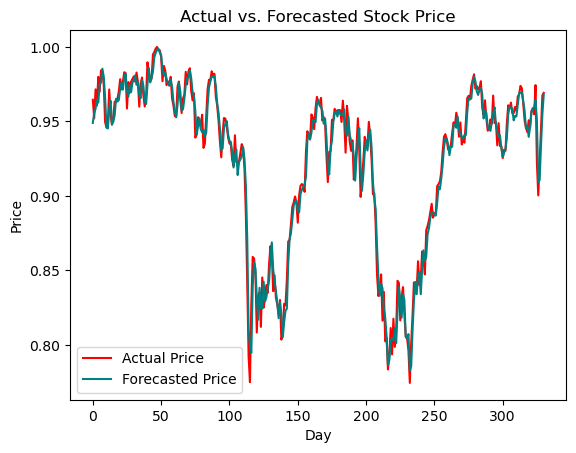

<Figure size 1500x10000 with 0 Axes>

In [35]:
time_axis = range(len(y_test))
plt.plot(time_axis, y_test, label='Actual Price', color='red')
plt.plot(time_axis, y_LSTM_M, label='Forecasted Price', color='teal')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Actual vs. Forecasted Stock Price')
plt.legend()
plt.figure(figsize=(15,100))
plt.show()